<a href="https://colab.research.google.com/github/chavamoon/MachineLearningExamples/blob/main/MNIST_Neural_Network_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Ejemplo de entrenamiento de una red reuronal para reconocer dígitos escritos a mano de MNIST

Definición de parámetros generales

In [2]:
# Diccionarios de argumentos
args = {}
kwargs = {}

# Configuración de tamaño de lote o batch en entrenamiento y validación
args['batch_size'] = 1000
args['test_batch_size'] = 1000

#Hiperparámetros de entrenamiento
# Epoch -> Númer de veces que pasamos por todos los datos
args['epoch'] = 10
# la tasa de aprendizaje (learning rate) del descenso por gradiente
args['lr'] = 0.01
# El momento o momentum del descenso por gradiente, necesario para un descenso de gradiente estocástico.
args['momentum'] = 0.5

#Parámetros de pytorch
#Semilla aleatoria
args['seed'] = 345
#cada cuanto habrá logs
args['log_interval'] = 10
#usar GPU si existe (cuda), de lo contrario cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args['cuda'] = device
print('Args:', args)

Args: {'batch_size': 1000, 'test_batch_size': 1000, 'epoch': 10, 'lr': 0.01, 'momentum': 0.5, 'seed': 345, 'log_interval': 10, 'cuda': device(type='cpu')}


## Lectura de los datos

Se cargan los datos y se dividen en entrenamiento y pruebas.

```
torch.utils.data.DataLoader
```

DataLoader permite cargar lso datos y prepararlos para el entrenamiento y validación.

Principales parámetros:
- datasets = Datos que queremos
- batch_size = Tamaño del lote o del batch de etrenamiento
- shuffle = Si se quiere revolver el dataset en cada época

```
datasets.MNIST
```
Llama a los datos MNIST

Principales parámetros:
- root -> Directorio donde existen o descargarán las imágenes o datos
- train -> Si utiliza datos de entrenamiento o no
- download -> Si se descargan los datos o no. Si los datos ya están en local no descarga
- transform -> Si aplica transformación a las imágenes

```
transforms.Compose
```
Permite anifar transformaciones, parecido a sequential utilizado para construir redes, pero a transformaciones.

En este caso pasamos dos transformaciones:
* transform.ToTensor -> Convierte las imágenes a un tensor
* transform.Normalze -> Normaliza los tensores. Debemos aplicar la misma normalización a los datos de entrenamiento que a los de prueba.

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data',
                   train = True,
                   download = True,
                   transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=args['batch_size'],
    shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Media y desviación estandar de un lote

In [4]:
#Obtenemos primer batch
examples = enumerate(train_loader)
# example_data tiene los datso en pixeles de cada observación
# example_targets tiene las etiquetas de la observación
batch_idx, (example_data, example_targets) = next(examples)

#En este caso canales = 1 porque son imágenes en blanco y negro
print('Dimensión del batch (Número de observaciones, canales, altura, ancho:', example_data.shape)
print('Media del batch:', torch.mean(example_data))
print('Std del batch:', torch.std(example_data))
print('Contenido de una observación en formato tensorial \n', example_data[0][0])
# 0 = negro 1 tiende a blanco
print('Valor de la observación \n', example_targets[0])

Dimensión del batch (Número de observaciones, canales, altura, ancho: torch.Size([1000, 1, 28, 28])
Media del batch: tensor(0.1310)
Std del batch: tensor(0.3088)
Contenido de una observación en formato tensorial 
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

Graficamos una observación


([], <a list of 0 Text major ticklabel objects>)

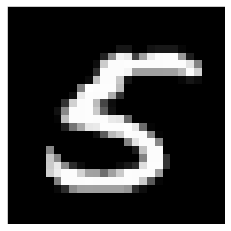

In [5]:
fig = plt.figure()
plt.tight_layout()
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])

Media y desviación estandar de todos los batches de entrenamiento

In [6]:
examples = enumerate(train_loader)

# Listas para guardar resultados por batch
batch_mean = []
batch_std = []
batch_labels = []

for batch_idx, (example_data, example_targets) in examples:
  batch_mean.append(torch.mean(example_data).item())
  batch_std.append(torch.std(example_data).item())
  batch_labels.append(example_targets)

# Convertir las etiquetas a numpy array
batch_labels = map(lambda x: x.numpy(), batch_labels )
batch_labels = np.concatenate(list(batch_labels))
#todas las etiquetas de las imágenes
batch_labels

array([0, 6, 7, ..., 5, 0, 1])

Gráfica de la distribución de las etiquetas en el set de datos

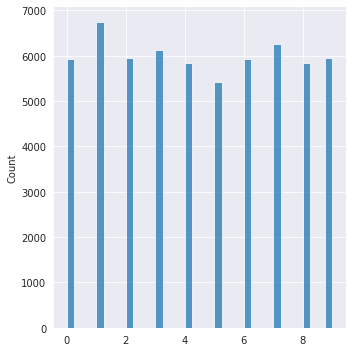

In [7]:
sns.displot(data=batch_labels)

Histograma de la media de los pixeles

Media de pixeles:   0.1306604787707329


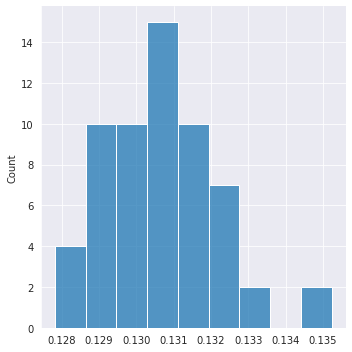

In [8]:
sns.displot(data=batch_mean)
print('Media de pixeles:  ',sum(batch_mean)/len(batch_mean))

Histograma de la desviación estandar de los pixeles

Std de pixeles:   0.30810109674930575


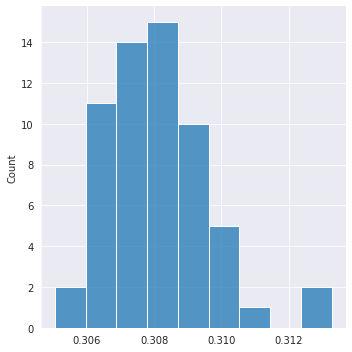

In [9]:
print('Std de pixeles:  ',sum(batch_std)/len(batch_std))
sns.displot(data=batch_std)

Vistazo a los datos de prueba

* Sin normalización

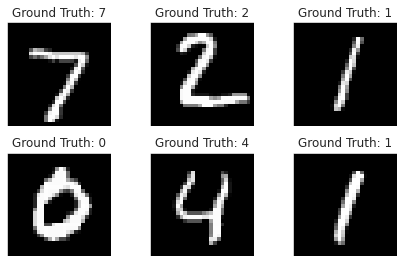

In [10]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=False)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

#Vistazo a los primeros 6 números
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


Normalizando

torch.Size([1000, 1, 28, 28])


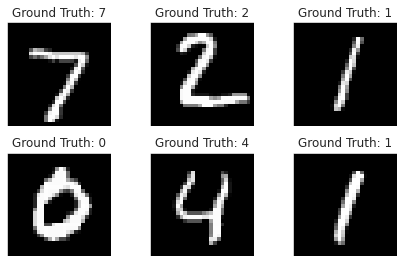

In [11]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((sum(batch_mean)/len(batch_mean),), (sum(batch_std)/len(batch_std),))
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=False)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


 En este caso a simple vista no hay mucha diferencia, aun asi es importante normalizar!
En esta ocasion como las imagenes son en blanco y negro, solo tenemos un canal.

Cargado final, con normalizaciones.

In [12]:
#load the data
avg_mean = sum(batch_mean)/len(batch_mean)
avg_std =  sum(batch_std)/len(batch_std)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((avg_mean,), (avg_std,))
                   ])),
    batch_size=args['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', 
                   train=False, 
                   download = True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((avg_mean,), (avg_std,))
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=True)

Resumen;
+ Cargado de los datos, y los hemos dividido entre entrenamiento y prueba.
+ Hemo visto la distribucion de las etiquetas (labels) en el entrenamiento, que parece bastante balanceada.
+ Hemos obtenido la media y std de los datos de entrenamiento.
+ Normalizamos los datos.
+ Revisamos la integridad de los datos.  
Hemos realizado con exito el ETL, y parte del EDA

## Definición de la clase de la red neuronal

In [13]:
from torch import nn

class NeuralNetwork(nn.Module):

    def __init__(self, in_n=784, hidden_n=256, out_n=1):
        super(NeuralNetwork, self).__init__()
        
        # W0:= Pesos entrada -> oculta 
        # nn.Linear(neuronas de entrada, neuronas ocultas, bias=True)
        self.hidden = nn.Linear(in_n, hidden_n)

        # W1:= Pesos oculta -> salida 
        # nn.Linear(neuronas ocultas, neuronas salida, bias=True)
        self.output = nn.Linear(hidden_n, out_n)
        
        # Funciones de Activacion 
        # Sigma 1 [capa oculta]
        self.sigmoid = nn.Sigmoid()
        # Sigma 2 [capa de salida]
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Flujo o feedforward de nuestra red

        # Flatten tensores de imagenes
        x = x.view(x.size(0), -1)
        # Multiplicacion de X0 por W0
        x = self.hidden(x)
        # Evaluar Sigma uno / Obtener X1
        x = self.sigmoid(x)
        # Multiplicacion de X1 por W1
        x = self.output(x)
        # Evaluar en Sigma 2 / Obtener X2
        # es log_softmax, debido a que la función de pérdida que utilizaremos es Negative log-likelihood loss
        x = F.log_softmax(x, dim=1)
        return x

## Evaluación del modelo

* **model.eval:**= Pone al modelo en modo de evaluacion. No calcula el gradiente, y desactiva el comportamiento de entrenamiento. Por ejemplo, descativa el dropout de neuronas.
* **.cuda()** := carga el tensor al GPU
* **F.nll_loss** := Funcion negative log-likelihood
* **output.data.max:**= Nos regresa el valor maximo del tensor, y el indice que le corresponde.

In [38]:
def prueba(model, test_loader, args):
  # Modelo en modo evaluación (elimina dropouy y no calcula el gradiente)
  model.eval()
  test_loss = 0
  correct = 0

  #iterar sobre cada batch/lote de prueba
  for data, target in test_loader:
    #usar gpu en lo que se pueda
    #nota: la comunicación entre cpu y gpu puede llegar a ser tardada
    if args['cuda'] == 'cuda':
      data, target = data.cuda(), target.cuda()
    
    # resultado del feedforward
    output = model(data)

    #función de pérdida en el batch. Negative log-likelihood loss
    test_loss += F.nll_loss(output, target, reduction='sum').item()

    #obtener la neurora  -> label con mayor probabilidad
    #la neurona k coresponde al número k o etiqueta k
    pred = output.data.max(1, keepdim=True)[1]

    #Número de predicciones correctas, .cpu() copia los tensores al cpu
    correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

  # % de observaciones correctas
  test_loss /= len(test_loader.dataset)

  print('\n Datos de Prueba: Perdida: {:.3f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [39]:
model_nn = NeuralNetwork(in_n=784, hidden_n=256, out_n=10)
prueba(model = model_nn, test_loader=test_loader, args=args)


 Datos de Prueba: Perdida: 2.321, Accuracy: 1148/10000 (11%)



Podemos observar que nuestra red no esta entrenada de manera optima, pues el accuracy es cercano al 10%. Esto es equivalente a elegir al azar.

Debemos entrenar nuestra red.

## Función de entrenamiento

Definamos la funcion de entrenamiento, para una epoca. Nuestro modelo evalua cada lote/batch una vez.

* **model.train()**:= Pone al modelo en modo de entrenamiento. Activa el dropout y calcula el gradiente.
* **Variable()**:= Es un wrapper alrededor de la clase tensor de Pytorch, que permite guardar operaciones intermedias, y calcular el gradiente. **Es un método deprecado**
* **.backward()**:= Computa el gradiente de los pesos, con la informacion de un objeto tipo Variable.
* **step.()**:= Calcula/actualiza los pesos de acuerdo al gradiente.

In [40]:
def entrenamiento(model, train_loader, args, epoch):
    # Pone al modelo en modo entrenamiento. Calcula autograd, y activa el dropout.
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # carga las matrices al GPU de ser necesario
        if args['cuda'] == 'cuda':
            data, target = data.cuda(), target.cuda()

        # Convierte el tensor a Variable para calcular la derivada 
        #data, target = Variable(data), Varaible(target)
        data, target = data, target

        # Reinicia el gradiente del lote a 0
        optimizer.zero_grad()

        # Feedforward
        output = model(data)

        # Calcula la perdida log-loss
        loss = nn.NLLLoss()
        loss = loss(output, target)

        # Calcula el gradiente (backward) 
        loss.backward()

        # Optimiza/recalcula los pesos
        optimizer.step()

        # Imprime la perdida. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

### Entrenamiento de una época

In [41]:
args['lr']=0.1
model_nn = NeuralNetwork(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])

for epoch in range(1, 2):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297177
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.858502
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.349968
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.037184
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.840908
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.699748

 Datos de Prueba: Perdida: 0.612, Accuracy: 8661/10000 (87%)



### Entrenamiento de más épocas

In [42]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']= 5 
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.1

model_nn = NeuralNetwork(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.354335
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.837771
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.332949
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.989982
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.827800
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.694832

 Datos de Prueba: Perdida: 0.607, Accuracy: 8673/10000 (87%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.651423
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.563676
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.510702
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.517731
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.470612
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.474279

 Datos de Prueba: Perdida: 0.417, Accuracy: 8914/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.410633
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.414802
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.367206
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.348425
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.418754
Train Epoch: 2 [50000/60000 (83%)]	Loss

### Entrenamiento con un learning rate grande

Esperariamos que nuestras predicciones se comportaran como pendulo, pues un learning rate grande tiende al sobre ajuste.

In [43]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch'] = 5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr'] = 1000


optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])

# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.311175
Train Epoch: 0 [10000/60000 (17%)]	Loss: 43188.503906
Train Epoch: 0 [20000/60000 (33%)]	Loss: 19452.923828
Train Epoch: 0 [30000/60000 (50%)]	Loss: 17549.650391
Train Epoch: 0 [40000/60000 (67%)]	Loss: 17420.378906
Train Epoch: 0 [50000/60000 (83%)]	Loss: 14953.050781

 Datos de Prueba: Perdida: 14105.809, Accuracy: 1028/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 13910.328125
Train Epoch: 1 [10000/60000 (17%)]	Loss: 12064.736328
Train Epoch: 1 [20000/60000 (33%)]	Loss: 6555.790039
Train Epoch: 1 [30000/60000 (50%)]	Loss: 15596.445312
Train Epoch: 1 [40000/60000 (67%)]	Loss: 14766.756836
Train Epoch: 1 [50000/60000 (83%)]	Loss: 13595.730469

 Datos de Prueba: Perdida: 11936.346, Accuracy: 1177/10000 (12%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 12569.392578
Train Epoch: 2 [10000/60000 (17%)]	Loss: 12767.064453
Train Epoch: 2 [20000/60000 (33%)]	Loss: 11435.403320
Train Epoch: 2 [30000/60000 (50%)]	Loss: 8630.991211
Train Epoch: 2 [40000/6

### Entrenamiento con learning rate pequeño

In [45]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.0001


model_nn = NeuralNetwork(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.379733
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.361256
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.370038
Train Epoch: 0 [30000/60000 (50%)]	Loss: 2.354182
Train Epoch: 0 [40000/60000 (67%)]	Loss: 2.359053
Train Epoch: 0 [50000/60000 (83%)]	Loss: 2.337951

 Datos de Prueba: Perdida: 2.351, Accuracy: 1009/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.352625
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.345863
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.344594
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.337265
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.347759
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.352893

 Datos de Prueba: Perdida: 2.341, Accuracy: 1008/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.346411
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.335805
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.340847
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.330778
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.336062
Train Epoch: 2 [50000/60000 (83%)]	Loss

En general Queremos que nuestro learning rate, se encuentre entre 0.0 y 1.0.

* Existe una compensacion inversa entre el learning rate, y el numero de epocas. Si tuvieramos tiempo y recuros, lo ideal seria tener un learning rate bajo y entrenar por muchas epocas.
* Tambien es conventiente intentar varios learning rates, con pocas epocas para detectar optimos locales, o en su defecto empezar con diferentes pesos iniciales, como en nuestro caso.

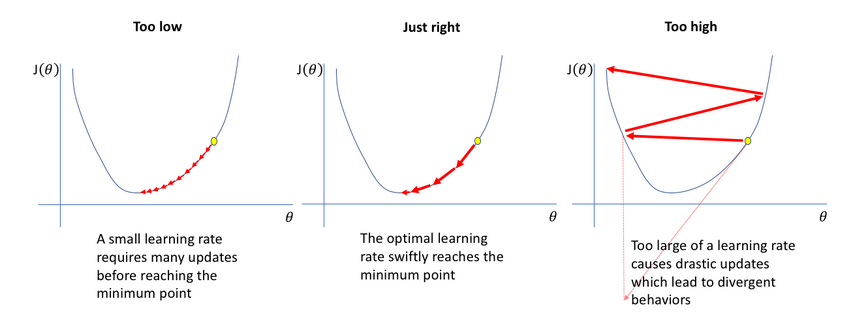

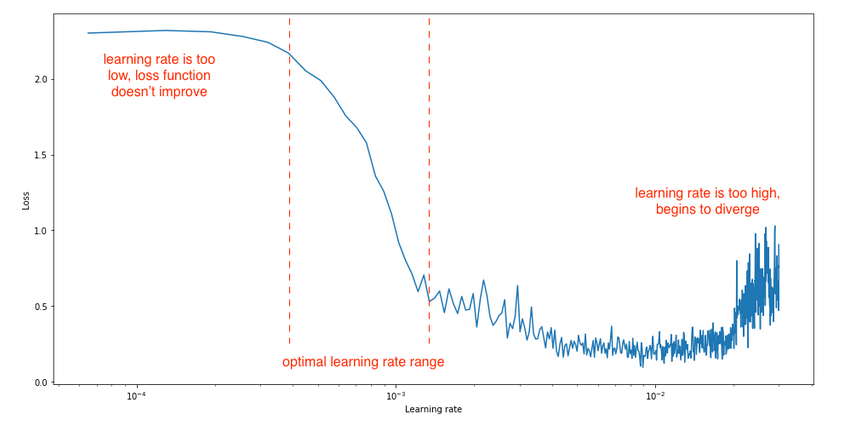

Fuente: https://www.kaggle.com/residentmario/tuning-your-learning-rate

### Entrenamiento con pocas neuronas

Solamente dos neuronas en la capa oculta

In [46]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=1.0


model_nn = NeuralNetwork(in_n=784, hidden_n=2, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.368591
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.156877
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.996270
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.909614
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.823692
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.763449

 Datos de Prueba: Perdida: 1.706, Accuracy: 3831/10000 (38%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.698008
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.629111
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.649647
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.538844
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.522186
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.585316

 Datos de Prueba: Perdida: 1.497, Accuracy: 4104/10000 (41%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.525970
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.543841
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.547008
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.535622
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.445795
Train Epoch: 2 [50000/60000 (83%)]	Loss

### Entrenamiento con muchas neuronas

In [47]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=1.0


model_nn = NeuralNetwork(in_n=784, hidden_n=5000, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.318213
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.685063
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.865970
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.488859
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.075175
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.807900

 Datos de Prueba: Perdida: 0.615, Accuracy: 8724/10000 (87%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.603349
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.661873
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.495098
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.538652
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.379726
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.344683

 Datos de Prueba: Perdida: 0.327, Accuracy: 9138/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.373593
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.425028
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.297479
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.249593
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.251414
Train Epoch: 2 [50000/60000 (83%)]	Loss